# LOCAL SEARCH - ANÁLISE DE RESULTADOS

 - ITA | PG-CTE-S | TE-282 - Meta-heurísticas
 - Professor Dr. Angelo Passaro
 - Aluno: Rafael Caneiro de Oliveira
 - Versao: 0.1
 - Data: 26/10/2021

## Bibliotecas | Parâmetros | Funções

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from ast import literal_eval

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log/")
print(LOG_PATH)


/Users/rco/github/s_metaheuristic/data/log


In [3]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

## Carrega Dados

In [4]:
df_stats_list = []
df_cov_mx_list =[]
for p in range(1,6,1):
    df_stats, df_cov_mx = read_port_files(p)
    df_stats_list.append(df_stats)
    df_cov_mx_list.append(df_cov_mx)
    
df_stats = pd.concat(df_stats_list)
df_cov_mx = pd.concat(df_cov_mx_list)

(31, 4)
(496, 4)
(85, 4)
(3655, 4)
(89, 4)
(4005, 4)
(98, 4)
(4851, 4)
(225, 4)
(25425, 4)


In [5]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}
df_stats['portfolio'] = df_stats.port.map(portfolios)
df_cov_mx['portfolio'] = df_cov_mx.port.map(portfolios)

In [6]:
uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [7]:
all_dfs = []
best_dfs = []
LOGs = str(LOG_PATH) + '/*.csv'

c = 0
for file in glob.glob(str(LOGs)):
    filename = file[file.find('/log/')+5:]
    try:
        df = pd.read_csv(file, low_memory=False, sep=',', quotechar='"')
        c = c + 1
    except:
        print('Arquivo não importado: {}'.format(filename))
    df['filename'] = filename
    df['Z'] = df.Z.apply(lambda x: literal_eval(x))
    df['X'] = df.X.apply(lambda x: literal_eval(x))
    df['k'] = df.Z.apply(lambda x: len(x))
    all_dfs.append(df)
    best_dfs.append(df.iloc[-1:])

all_data = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
all_data.rename({'move_strategy':'move_str',
                 'selection_strategy':'selec_str'}, axis=1, inplace=True)

best_data = pd.concat(best_dfs, ignore_index=True).reset_index(drop=True)
best_data.rename({'move_strategy':'move_str',
                  'selection_strategy':'selec_str'}, axis=1, inplace=True)

print('Importados {} arquivos'.format(c))

# for col in all_data.columns:
#     all_data[col] = pd.to_numeric(all_data[col])

# for col in best_data.columns:
#     best_data[col] = pd.to_numeric(best_data[col])

Importados 3911 arquivos


In [8]:
all_data.Z

0          [1, 3, 4, 7, 15, 24, 28]
1         [1, 3, 4, 15, 24, 27, 28]
2         [1, 3, 4, 24, 25, 27, 28]
3         [1, 3, 4, 16, 24, 25, 27]
4         [3, 4, 8, 16, 24, 25, 27]
                    ...            
198272                   [4, 8, 25]
198273                   [4, 8, 25]
198274                   [4, 8, 25]
198275                   [4, 8, 25]
198276                   [4, 8, 25]
Name: Z, Length: 198277, dtype: object

In [9]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198277 entries, 0 to 198276
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   iter        198277 non-null  int64  
 1   move        198277 non-null  object 
 2   improve     198277 non-null  bool   
 3   obj         198277 non-null  float64
 4   return      198277 non-null  float64
 5   n_assets    198277 non-null  int64  
 6   qX          198277 non-null  int64  
 7   qN          198277 non-null  int64  
 8   qNv         198277 non-null  int64  
 9   iter_time   198277 non-null  float64
 10  max_iter    198277 non-null  int64  
 11  neighbours  198277 non-null  int64  
 12  alpha       198277 non-null  float64
 13  exp_return  198277 non-null  float64
 14  n_port      196001 non-null  float64
 15  k_min       198277 non-null  int64  
 16  k_max       198277 non-null  int64  
 17  move_str    198277 non-null  object 
 18  seed        198219 non-null  float64
 19  se

In [10]:
# all_data.describe(include='all').T

## Portfólios

### Geral

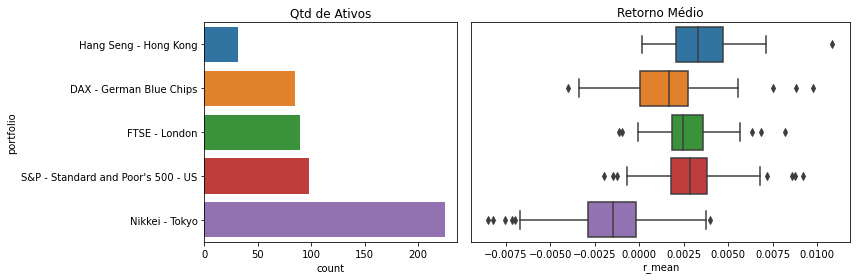

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [1, 1.5]})
sns.countplot(data=df_stats, y='portfolio', ax=ax[0])
ax[0].title.set_text('Qtd de Ativos')
sns.boxplot(data=df_stats, y='portfolio', x='r_mean', ax=ax[1])
ax[1].title.set_text("Retorno Médio")
ax[1].get_yaxis().set_ticks([])
ax[1].set_ylabel('')
fig.tight_layout()

### Matriz de Covariância

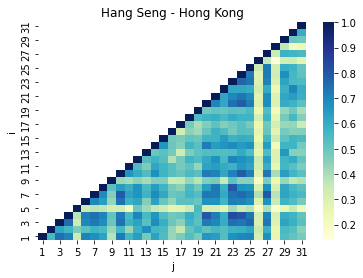

In [12]:
portfolio = 1
df_cov_pivot = df_cov_mx[df_cov_mx.port==portfolio].pivot(index='i', columns='j', values='cov')
sns.heatmap(df_cov_pivot.iloc[::-1], cmap="YlGnBu") 
plt.title(portfolios[portfolio])
ax=ax

### Fronteiras de Eficiência Irrestrira - UEF

In [13]:
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


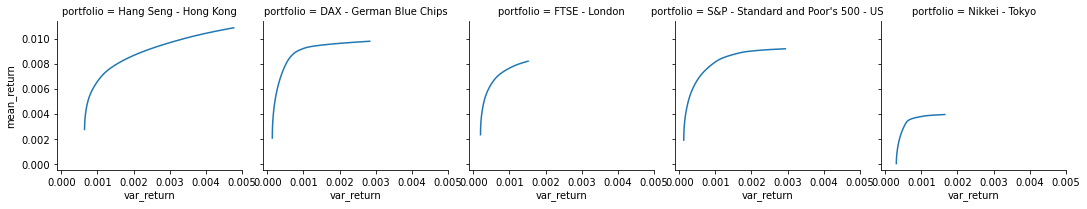

In [14]:
g = sns.relplot(data=uef, y='mean_return', x='var_return', col='portfolio', kind='line', height=3)
ax=ax

## Curvas de Aprendizado

### Avaliação do Impacto da Seed

In [15]:
# g = sns.FacetGrid(
#     data=all_data, row='seed', col='move_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

In [16]:
# g = sns.FacetGrid(
#     data=all_data, row='seed', col='selec_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

### Avaliação do Tipo de Move

In [17]:
# g = sns.FacetGrid(
#     data=all_data, row='selec_str', col='move_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

### Avaliação do Impacto do Retorno Experado

In [18]:
# g = sns.FacetGrid(
#     data=all_data, row='exp_return', col='move_str', hue='alpha')
# g.map(sns.lineplot, 'iter', 'obj')
# g.add_legend()
# g=g

## Análise Best - Portfólio 1

In [19]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


In [20]:
print(best_data.shape)
best_data.head()

(3911, 25)


,iter,move,improve,obj,return,n_assets,qX,qN,qNv,iter_time,...,k_min,k_max,move_str,seed,selec_str,tag,X,Z,filename,k
0,25,iDR,False,0.003226,0.002686,2,2,100,94,0.131089,...,2,15,best,64.0,best,bench_local,"[0.989964, 0.010036]","[24, 27]",log_local_search_20211102_172418_761663.csv,2
1,52,iDR,False,0.001835,0.007087,2,2,100,98,0.120435,...,2,15,best,11.0,random,bench_local,"[0.989275, 0.01]","[8, 25]",log_local_search_20211102_170053_508157.csv,2
2,46,iDR,False,0.002273,0.002463,2,2,100,46,0.035174,...,2,15,random,90.0,first,bench_local,"[0.01, 0.989119]","[4, 30]",log_local_search_20211102_172029_555390.csv,2
3,30,iDR,False,0.001381,0.002363,2,2,100,100,0.145836,...,2,15,best,59.0,first,bench_local,"[0.01, 0.99]","[25, 27]",log_local_search_20211102_165622_939237.csv,2
4,38,iDR,False,0.001712,0.010777,2,2,100,99,0.118368,...,2,15,best,20.0,random,bench_local,"[0.989654, 0.010346]","[4, 27]",log_local_search_20211102_164714_961978.csv,2


In [21]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,3911.0,49.697264,2.322524e+01,10.000000,28.000000,48.000000,61.000000,99.000000
obj,3911.0,0.005845,1.844747e-02,0.000247,0.001455,0.001659,0.002631,0.233801
return,3911.0,0.005817,3.105766e-03,0.001000,0.003277,0.004768,0.007092,0.010803
n_assets,3911.0,2.447712,1.335245e+00,2.000000,2.000000,2.000000,2.000000,14.000000
qX,3911.0,2.447712,1.335245e+00,2.000000,2.000000,2.000000,2.000000,14.000000
qN,3911.0,101.380721,3.522868e+01,100.000000,100.000000,100.000000,100.000000,1000.000000
qNv,3911.0,79.770136,4.086533e+01,0.000000,55.000000,97.000000,99.000000,904.000000
iter_time,3911.0,0.082703,4.676758e-02,0.018174,0.040467,0.060154,0.121712,0.552831
max_iter,3911.0,100.000000,0.000000e+00,100.000000,100.000000,100.000000,100.000000,100.000000
neighbours,3911.0,101.380721,3.522868e+01,100.000000,100.000000,100.000000,100.000000,1000.000000


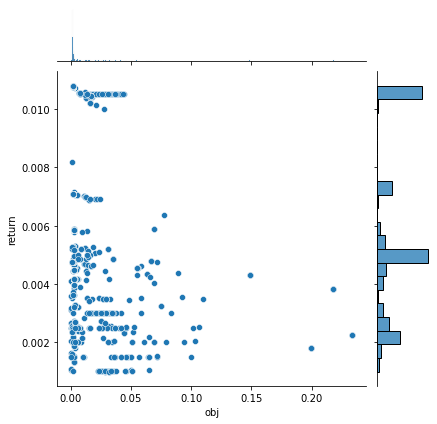

In [22]:
sns.jointplot(data=best_data, x='obj', y='return', palette='bright')

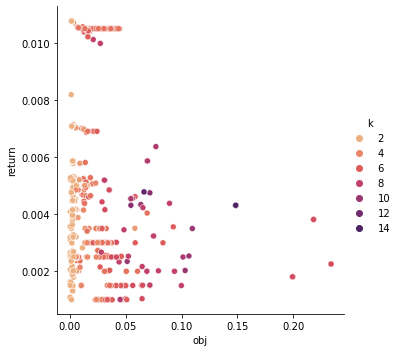

In [23]:
sns.relplot(data=best_data, x='obj', y='return', hue='k', palette='flare')

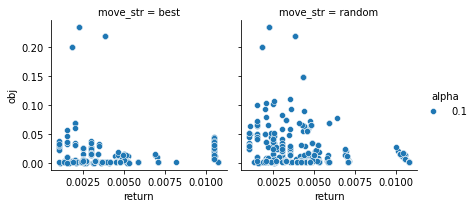

In [24]:
g = sns.FacetGrid(data=best_data, col='move_str', hue='alpha')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

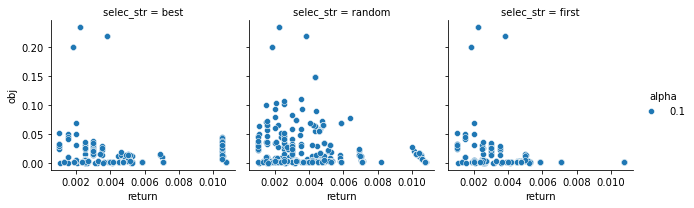

In [25]:
g = sns.FacetGrid(data=best_data, col='selec_str', hue='alpha')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

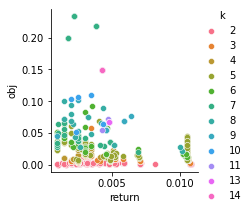

In [26]:
g = sns.FacetGrid(data=best_data, hue='k')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

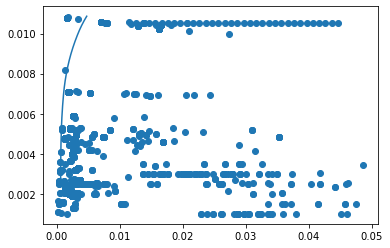

In [27]:
data = best_data[best_data['obj']<0.05]
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return)
plt.scatter(data.obj, data['return'])

Text(0, 0.5, 'mean_return')

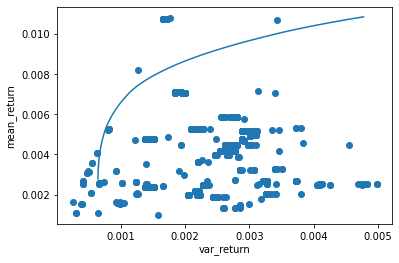

In [28]:
data = best_data[best_data['obj']<0.005]
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return)
plt.scatter(data.obj, data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

In [28]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .count()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return          0.0010  0.0015  0.0020  0.0025  0.0030  0.0035  0.0040  \
move_str selec_str                                                           
best     best           95      95      93      88      85      60      42   
         first          95      95      93      88      77      60      42   
         random         95      95      93      88      77      60      42   
random   best           95      95      93      88      77      60      42   
         first          95      95      93      88      77      60      42   
         random         95      95      93      88      77      60      42   

exp_return          0.0045  0.0050  0.0055  0.0060  0.0065  0.0070  0.0075  \
move_str selec_str                                                           
best     best           25      17      12       9       9       7       5   
         first          25      17      12       9       9       7       5   
         random         25      17      12       9       9       7       5   
random   best           25      17      12       9       9       7       5   
         first          25      17      12       9       9       7       5   
         random         25      17      12       9       9       7       5   

exp_return          0.0080  
move_str selec_str          
best     best            1  
         first           1  
         random          1  
random   best            1  
         first           1  
         random          1

In [29]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .min()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return            0.0010    0.0015    0.0020    0.0025    0.0030  \
move_str selec_str                                                     
best     best       0.000293  0.000386  0.000532  0.000416  0.000473   
         first      0.000293  0.000386  0.000532  0.000416  0.000473   
         random     0.000648  0.000383  0.001235  0.000662  0.000487   
random   best       0.001380  0.001380  0.001380  0.000405  0.001381   
         first      0.001380  0.001380  0.001380  0.000405  0.001381   
         random     0.000978  0.000247  0.001381  0.001220  0.001381   

exp_return            0.0035    0.0040    0.0045    0.0050    0.0055  \
move_str selec_str                                                     
best     best       0.000547  0.000626  0.001383  0.001653  0.001654   
         first      0.000547  0.000626  0.001383  0.001653  0.001654   
         random     0.001381  0.001380  0.001381  0.001258  0.001654   
random   best       0.001381  0.001381  0.001381  0.001654  0.001654   
         first      0.001381  0.001381  0.001381  0.001654  0.001654   
         random     0.001381  0.001381  0.001381  0.001654  0.001654   

exp_return            0.0060    0.0065    0.0070    0.0075    0.0080  
move_str selec_str                                                    
best     best       0.001655  0.001655  0.001655  0.001655  0.001718  
         first      0.001655  0.001655  0.001655  0.001655  0.001718  
         random     0.001654  0.001654  0.001654  0.001654  0.001655  
random   best       0.001654  0.001654  0.001654  0.001654  0.001654  
         first      0.001654  0.001654  0.001654  0.001654  0.001654  
         random     0.001654  0.001654  0.001654  0.001655  0.001655

In [30]:
best_best_data = best_data.groupby(['exp_return'], as_index=False)['obj'].min()
print(best_best_data.shape)
best_best_data.head()

(15, 2)


,exp_return,obj
0,0.0010,0.000293
1,0.0015,0.000247
2,0.0020,0.000532
3,0.0025,0.000405
4,0.0030,0.000473


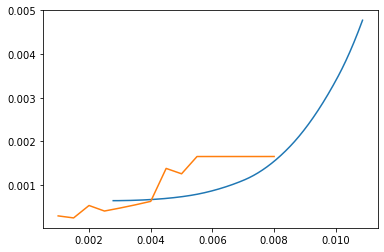

In [31]:
plt.plot(uef[uef.port==1].mean_return, uef[uef.port==1].var_return)
plt.plot(best_best_data.exp_return, best_best_data.obj)